In [81]:
import numpy as np
import matplotlib.pyplot as plt

from config import Config
from playground.environment import Environment

config = Config()
environment = Environment(config)

In [82]:
for o in environment.get_objects():
    print(o.name, o.task)

banana grasping
bike grasping
chips_can grasping
cracker_box grasping
domino grasping
hammer grasping
jenga grasping
master_chef_can grasping
medium_clamp grasping
mini_cheetah grasping
minitaur grasping
mug grasping
mustard_bottle grasping
power_drill grasping
scissors grasping
tomato_soup_can grasping
007 pushing
014 pushing
024 pushing
033 pushing
088 pushing
117 pushing
119 pushing
132 pushing
133 pushing
184 pushing
185 pushing
228 pushing
238 pushing
banana pushing
cracker_box pushing
gelatin_box pushing
mug pushing
power_drill pushing
000 hammering
007 hammering
011 hammering
016 hammering
024 hammering
057 hammering
058 hammering
078 hammering
081 hammering
083 hammering
090 hammering
114 hammering
115 hammering
126 hammering
147 hammering
157 hammering
hammer hammering


In [83]:
ls = environment.storage._latent_similarities

In [84]:
vs = np.zeros((config.OBJ_NUM, config.OBJ_NUM))
for i in range(config.OBJ_NUM):
    for j in range(config.OBJ_NUM):
        vs[i, j] = environment.storage.get_visual_similarity(i, j)

In [85]:
print(ls)
print(vs)

[[0.9 0.1 0.  ... 0.  0.  0. ]
 [0.3 0.9 0.1 ... 0.  0.  0. ]
 [0.  0.  1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.7 0.7 0.4]
 [0.  0.  0.  ... 0.2 0.9 0.4]
 [0.  0.  0.  ... 0.  0.  0.8]]
[[1.         0.27857245 0.28085761 ... 0.         0.         0.        ]
 [0.27857245 1.         0.47871957 ... 0.         0.         0.        ]
 [0.28085761 0.47871957 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.81953359 0.25309289]
 [0.         0.         0.         ... 0.81953359 1.         0.24815944]
 [0.         0.         0.         ... 0.25309289 0.24815944 1.        ]]


The format of the data is as follows:
All values are between 0 and 1. The visual similarity of objects in different tasks is manually set to 0, since transferring between tasks does not make much sense. Thus, the two matrices are block diagonal, with 3 non-zero blocks for the three tasks. 

In [86]:
print("Average visual similarity", vs.mean(), vs.std())
print("Average real transfer success rate", ls.mean(), ls.std())

Average visual similarity 0.18941243402240296 0.314433995285596
Average real transfer success rate 0.13429450211457133 0.2541927769683696


It seems the average visual similarity is higher than the average transfer success rate, which makes sense, since even objects that are quite different will have some visual similarity but they can easily have 0 transfer successes. Also, the standard deviation of the visual similarity dataset is higher. 

In [87]:
ls_flat = ls.flatten()
vs_flat = vs.flatten()

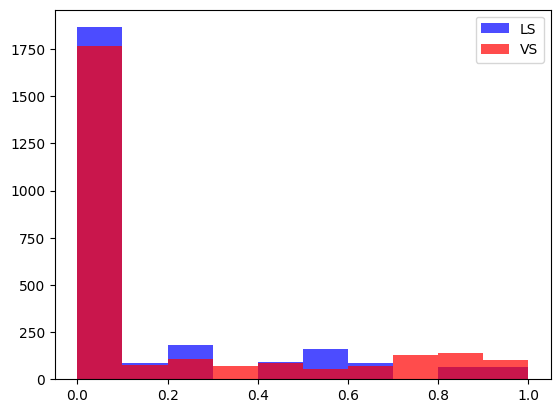

In [88]:
bins = np.histogram(np.hstack((list(ls_flat), list(vs_flat))), bins=10)[1]
plt.hist(list(ls_flat), bins, alpha=0.7, label='LS', color='b')
plt.hist(list(vs_flat), bins, alpha=0.7, label='VS', color='r')
plt.legend()
plt.show()

As expected, most values in both arrays are zeros. It seems the real transfers have more zeros (which is expected because there will always be some similarity between two images whereas transferring from one object to another can easily have exactly 0 successes).

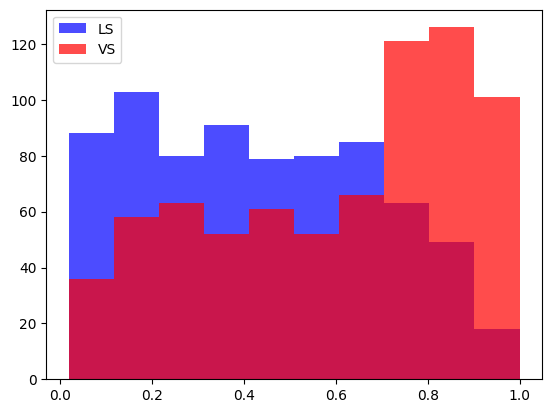

In [89]:
# filter out the zeros in the latent similarities
ls_flat_filtered = ls_flat[ls_flat > 0]
vs_flat_filtered = vs_flat[ls_flat > 0]
bins = np.histogram(np.hstack((list(ls_flat_filtered), list(vs_flat_filtered))), bins=10)[1]
plt.hist(list(ls_flat_filtered), bins, alpha=0.7, label='LS', color='b')
plt.hist(list(vs_flat_filtered), bins, alpha=0.7, label='VS', color='r')
plt.legend()
plt.show()

Having filtered out the zeros in the latent similarities we get a nice and readable histogram which shows that the visual similarities have a distribution which could be approximated with two Gaussians, whereas the distribution of the transfer success rate looks more like a flat single Gaussian. I suspect the reason is the PUSHING and HAMMERING tasks result in this bulge in the high visual similarities, since all those objects are visually quite similar but have slightly different interaction dynamics. It might be thus necessary to consider the distributions separately for each task.

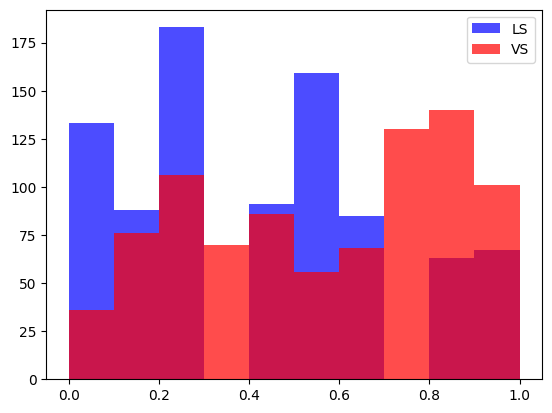

In [90]:
# filter out the zeros in the visual similarities
ls_flat_filtered = ls_flat[vs_flat > 0]
vs_flat_filtered = vs_flat[vs_flat > 0]
bins = np.histogram(np.hstack((list(ls_flat_filtered), list(vs_flat_filtered))), bins=10)[1]
plt.hist(list(ls_flat_filtered), bins, alpha=0.7, label='LS', color='b')
plt.hist(list(vs_flat_filtered), bins, alpha=0.7, label='VS', color='r')
plt.legend()
plt.show()

The histogram with zeros in the visual similarities is harder to interpret. Logically, this should filter out only the zeros from different tasks. The transfer success rate distribution looks very choppy, with three separate peaks. 

In [91]:
print("Average visual similarity", vs_flat_filtered.mean(), vs_flat_filtered.std())
print("Average real transfer success rate", ls_flat_filtered.mean(), ls_flat_filtered.std())

Average visual similarity 0.566929506205144 0.2861782780969094
Average real transfer success rate 0.4019562715765247 0.292929087548136


Computing the mean and standard deviation of the filtered datasets yields results as expected. The average visual similarity is higher by about 0.1 and the dataset has a slightly higher standard deviation.

## Let us now investigate the correlation between the two features
First, let's plot one against the other

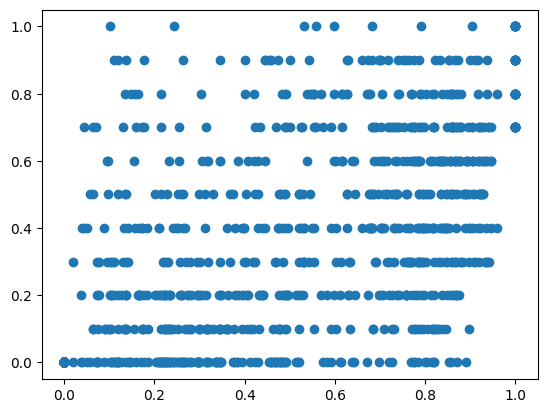

In [92]:
plt.scatter(vs_flat, ls_flat)

Visually, the two features don't look too correlated, but we can filter out zeros as before to hopefully make it more readable

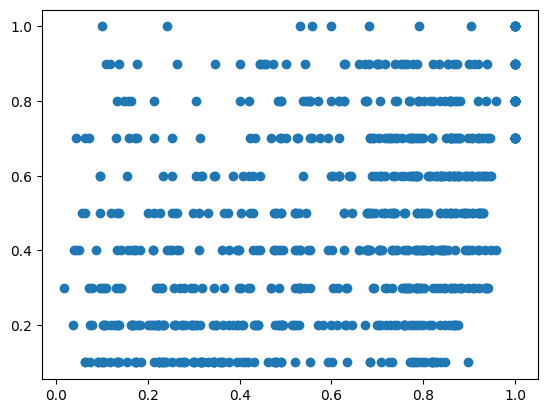

In [93]:
ls_flat_filtered = ls_flat[ls_flat > 0]
vs_flat_filtered = vs_flat[ls_flat > 0]
plt.scatter(vs_flat_filtered, ls_flat_filtered)

While the number of zeros is much smaller and the density of the data is moved more towards larger visible similarity, the distribution looks very noisy.

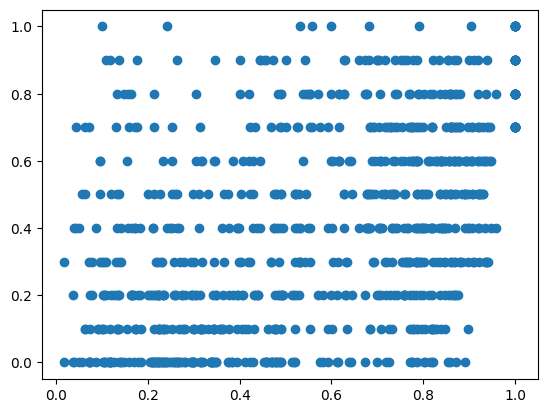

In [94]:
ls_flat_filtered = ls_flat[vs_flat > 0]
vs_flat_filtered = vs_flat[vs_flat > 0]
plt.scatter(vs_flat_filtered, ls_flat_filtered)

Let us now calculate some correlation coefficients, starting with Pearson's.

In [95]:
from scipy.stats import pearsonr

corr, _ = pearsonr(vs_flat, ls_flat)
print("The Pearson's correlation of the whole dataset", corr)
ls_flat_filtered = ls_flat[ls_flat > 0]
vs_flat_filtered = vs_flat[ls_flat > 0]
corr, _ = pearsonr(vs_flat_filtered, ls_flat_filtered)
print("The Pearson's correlation of the dataset with latent zeros filtered out", corr)
ls_flat_filtered = ls_flat[vs_flat > 0]
vs_flat_filtered = vs_flat[vs_flat > 0]
corr, _ = pearsonr(vs_flat_filtered, ls_flat_filtered)
print("The Pearson's correlation of the dataset with visible zeros filtered out", corr)

The Pearson's correlation of the whole dataset 0.8003244688215007
The Pearson's correlation of the dataset with latent zeros filtered out 0.39788975575867125
The Pearson's correlation of the dataset with visible zeros filtered out 0.4737594281653006


It can be seen that we only get significant correlation when zeros are not filtered out. This is however meaningless, since the zeros are manually set for objects that don't share tasks and it has no predictive value for the application.

Let us now see if some other coefficients might work better for the data. Let us consider Spearman's Correlation which summarises the strength between two data samples.  

In [96]:
from scipy.stats import spearmanr

corr, _ = spearmanr(vs_flat, ls_flat)
print("The Spearman's correlation of the whole dataset", corr)
ls_flat_filtered = ls_flat[ls_flat > 0]
vs_flat_filtered = vs_flat[ls_flat > 0]
corr, _ = spearmanr(vs_flat_filtered, ls_flat_filtered)
print("The Spearman's correlation of the dataset with latent zeros filtered out", corr)
ls_flat_filtered = ls_flat[vs_flat > 0]
vs_flat_filtered = vs_flat[vs_flat > 0]
corr, _ = spearmanr(vs_flat_filtered, ls_flat_filtered)
print("The Spearman's correlation of the dataset with visible zeros filtered out", corr)

The Spearman's correlation of the whole dataset 0.8957699537705063
The Spearman's correlation of the dataset with latent zeros filtered out 0.4107873682883309
The Spearman's correlation of the dataset with visible zeros filtered out 0.4806909308990202


Again, the only meaningful correlation is found for the non-filtered data. Perhaps considering the entire dataset is not a good idea.

## Considering tasks separately

In [97]:
start_g, stop_g = 0, 16 
start_p, stop_p = 17, 34 
start_h, stop_h = 35, 51 
grasping_ls = ls[start_g: stop_g, start_g: stop_g]
grasping_vs = vs[start_g: stop_g, start_g: stop_g]
pushing_ls = ls[start_p: stop_p, start_p: stop_p]
pushing_vs = vs[start_p: stop_p, start_p: stop_p]
hammering_ls = ls[start_h: stop_h, start_h: stop_h]
hammering_vs = vs[start_h: stop_h, start_h: stop_h]

print(grasping_ls)
print(grasping_vs)
print(pushing_ls)
print(pushing_vs)
print(hammering_ls)
print(hammering_vs)

[[0.9 0.1 0.  0.6 0.  1.  0.  0.  0.5 0.4 0.5 0.3 0.  0.7 0.4 0.2]
 [0.3 0.9 0.1 0.9 0.1 0.9 0.4 0.3 0.7 0.8 0.9 0.6 0.1 0.7 0.6 0. ]
 [0.  0.  1.  0.2 0.4 0.  0.  0.7 0.  0.5 0.  0.5 0.4 0.1 0.  0.8]
 [0.1 0.4 0.1 1.  0.4 0.2 0.6 0.2 0.  0.7 1.  0.6 0.5 0.9 0.4 0.4]
 [0.2 0.  0.  0.2 0.9 0.3 0.  0.  0.2 0.1 0.3 0.  0.  0.  0.2 0. ]
 [0.3 0.  0.  0.4 0.2 1.  0.6 0.3 0.  0.  0.  0.1 0.  0.3 0.2 0. ]
 [0.2 0.9 0.3 0.9 0.2 0.3 1.  0.4 0.4 0.2 0.4 0.2 0.1 0.4 0.4 0.2]
 [0.  0.  0.7 0.  0.3 0.  0.  0.8 0.  0.3 0.1 0.6 0.7 0.1 0.  0.6]
 [0.2 0.8 0.  0.2 0.2 0.9 0.4 0.2 1.  0.9 0.8 0.7 0.1 0.5 0.8 0. ]
 [0.5 0.6 0.1 0.6 0.4 0.7 0.5 0.9 0.7 1.  1.  0.7 0.1 0.9 0.7 0.3]
 [0.  0.6 0.  0.  0.1 0.5 0.5 0.3 0.6 0.9 1.  0.4 0.1 0.1 0.7 0.1]
 [0.  0.  0.5 0.1 0.2 0.1 0.  0.3 0.  0.4 0.1 1.  0.4 0.  0.  0.7]
 [0.  0.  0.5 0.1 0.2 0.  0.  0.2 0.  0.2 0.1 0.3 0.7 0.1 0.  0.8]
 [0.1 0.  0.2 0.7 0.1 0.7 0.1 0.4 0.2 0.5 0.8 0.8 0.5 1.  0.2 0. ]
 [0.8 0.2 0.  0.3 0.  0.8 0.4 0.  0.9 0.8 0.4 0.2 0.  0.5 0.8 

In [98]:
def print_basic_info(vs, ls, task):
    print("Average visual similarity", vs.mean(), vs.std(), "for task", task)
    print("Average real transfer success rate", ls.mean(), ls.std(), "for task", task)
    

print_basic_info(grasping_vs, grasping_ls, "grasping")
print_basic_info(pushing_vs, pushing_ls, "pushing")
print_basic_info(hammering_vs, hammering_ls, "hammering")

Average visual similarity 0.3745431387972061 0.232141308781192 for task grasping
Average real transfer success rate 0.350390625 0.3216167710367564 for task grasping
Average visual similarity 0.5243866829684299 0.2780301366144265 for task pushing
Average real transfer success rate 0.38823529411764707 0.3077994223988501 for task pushing
Average visual similarity 0.7681152168064549 0.20002724543895656 for task hammering
Average real transfer success rate 0.4609375 0.24262058052389127 for task hammering


As expected and described above, PUSHING and HAMMERING tasks have significantly higher visual similarity scores across all objects. The transfer success rates are more or less similar for all three tasks and are around 0.4. That means breaking up the data by task was a good approach.

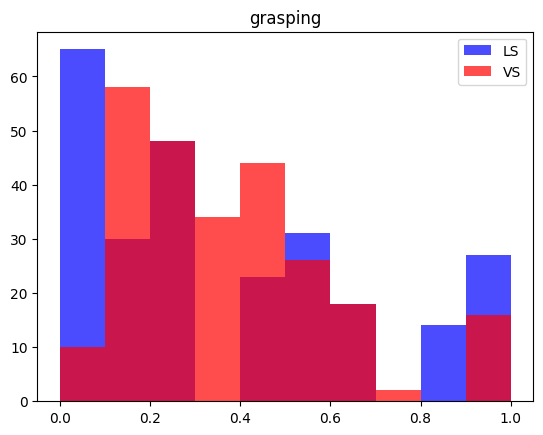

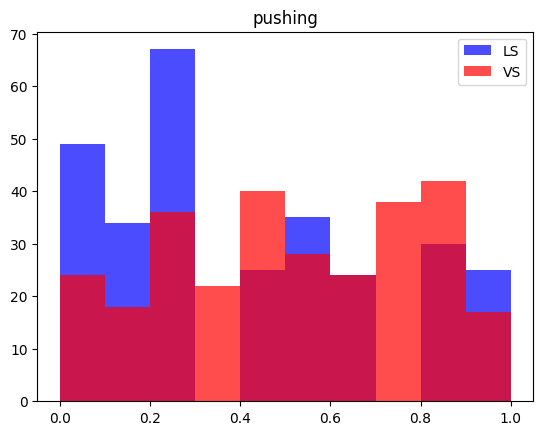

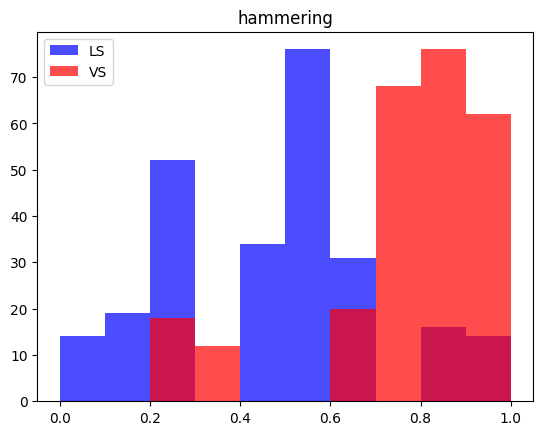

In [99]:
def show_histograms(vs, ls, task):
    bins = np.histogram(np.hstack((list(ls), list(vs))), bins=10)[1]
    plt.hist(list(ls), bins, alpha=0.7, label='LS', color='b')
    plt.hist(list(vs), bins, alpha=0.7, label='VS', color='r')
    plt.legend()
    plt.title(task)
    plt.show()
    
    
show_histograms(grasping_vs.flatten(), grasping_ls.flatten(), "grasping")
show_histograms(pushing_vs.flatten(), pushing_ls.flatten(), "pushing")
show_histograms(hammering_vs.flatten(), hammering_ls.flatten(), "hammering")

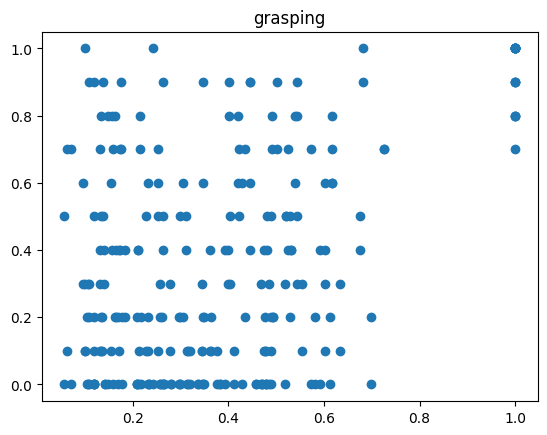

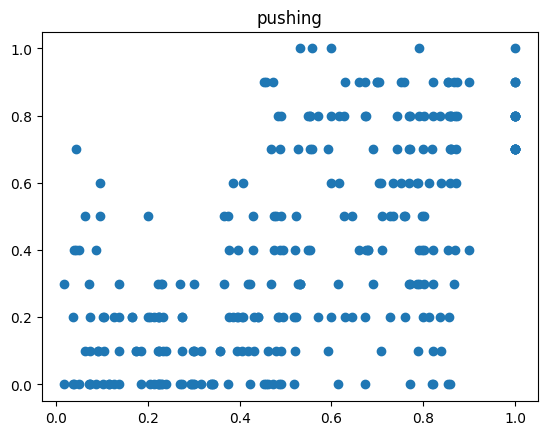

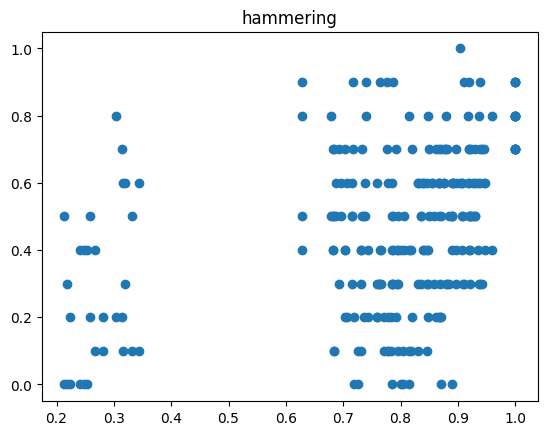

In [100]:
def plot_scatter(vs, ls, task):
    plt.scatter(vs, ls)
    plt.title(task)
    plt.show()
    
    
plot_scatter(grasping_vs.flatten(), grasping_ls.flatten(), "grasping")
plot_scatter(pushing_vs.flatten(), pushing_ls.flatten(), "pushing")
plot_scatter(hammering_vs.flatten(), hammering_ls.flatten(), "hammering")

In [101]:
def print_correlation_coefficients(vs, ls, task):
    corr, _ = pearsonr(vs, ls)
    print("The Pearson's correlation for task", task, "is", corr)
    corr, _ = spearmanr(vs, ls)
    print("The Spearman's correlation for task", task, "is", corr)
    
    
print_correlation_coefficients(grasping_vs.flatten(), grasping_ls.flatten(), "grasping")
print_correlation_coefficients(pushing_vs.flatten(), pushing_ls.flatten(), "pushing")
print_correlation_coefficients(hammering_vs.flatten(), hammering_ls.flatten(), "hammering")

The Pearson's correlation for task grasping is 0.39575437028492344
The Spearman's correlation for task grasping is 0.25340984934364524
The Pearson's correlation for task pushing is 0.5958372107225673
The Spearman's correlation for task pushing is 0.589361800592416
The Pearson's correlation for task hammering is 0.36838086851808216
The Spearman's correlation for task hammering is 0.3892533275387976


The correlation coefficients are still rather low, and all apart from PUSHING are not high enough to be notable. This is an interesting result, since the objects used for the pushing task are all relatively similar and I would expect the DINO similarities to be high for any pair. However, we can see from the above histogram, that the visual similarity measures are roughly evenly distributed. 